In [1]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pprint
import csv
import ast
import sys


from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile

import re

In [3]:
### Importer un module de fonctions crée ad hoc
## ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans le même dossier que le présent carnet Jupyter afin que l'importation
#   fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
#sys.path.insert(0, '../..')



import sparql_functions as spqf

In [4]:
### Fonction qui récupère et met en forme le temps au moment de l'exécution

# définition
def timestamp_formatted_for_file_name():
    is_now = time.strftime('%Y%m%d_%H%M%S')
    return is_now

# exécution
timestamp_formatted_for_file_name()

'20240322_204359'

## SPARQL Query

In [5]:
## define SPARQL enpoint
endpoint = "https://query.wikidata.org/sparql"

In [6]:
query = """
SELECT DISTINCT ?item ?itemLabel ?coordinates ?battle_date ?start_time ?end_time
    WHERE {
        {
          {?item wdt:P31 wd:Q178561.
                 OPTIONAL {?item wdt:P625 ?coordinates.
                          ?item wdt:P585 ?battle_date}
                 OPTIONAL {?item wdt:P580 ?start_time;
                            wdt:P582 ?end_time}         
      FILTER(bound(?battle_date))

      # BIND(xsd:integer(REPLACE(str(?battle_date), "(.*)([0-9]{4})(.*)", "$2")) AS ?battle_year)
      
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
        }  
      }
    }  
"""

In [7]:
### Execute the SPARQL query
qr = spqf.get_json_sparql_result(endpoint,query)


<class 'dict'>


In [8]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

6433


[['http://www.wikidata.org/entity/Q543255',
  'Battle of Taranto',
  'Point(17.2075 40.451111111)',
  '1940-11-12T00:00:00Z',
  '1940-11-11T00:00:00Z',
  '1940-11-12T00:00:00Z'],
 ['http://www.wikidata.org/entity/Q193993',
  'Battle of Pea Ridge',
  'Point(-94.034694444 36.454388888)',
  '1862-01-01T00:00:00Z',
  '1862-03-07T00:00:00Z',
  '1862-03-08T00:00:00Z'],
 ['http://www.wikidata.org/entity/Q283015',
  'Battle of Beaugency',
  'Point(1.64917 46.7958)',
  '1429-06-26T00:00:00Z',
  '1429-07-04T00:00:00Z',
  '1429-07-05T00:00:00Z']]

In [9]:
df_b = pd.DataFrame(r)
df_b.columns = ['uri', 'label', 'geo_coordinates', 'battle_date', 'start_time', 'end_time']
df_b.head()

,uri,label,geo_coordinates,battle_date,start_time,end_time
0,http://www.wikidata.org/entity/Q543255,Battle of Taranto,Point(17.2075 40.451111111),1940-11-12T00:00:00Z,1940-11-11T00:00:00Z,1940-11-12T00:00:00Z
1,http://www.wikidata.org/entity/Q193993,Battle of Pea Ridge,Point(-94.034694444 36.454388888),1862-01-01T00:00:00Z,1862-03-07T00:00:00Z,1862-03-08T00:00:00Z
2,http://www.wikidata.org/entity/Q283015,Battle of Beaugency,Point(1.64917 46.7958),1429-06-26T00:00:00Z,1429-07-04T00:00:00Z,1429-07-05T00:00:00Z
3,http://www.wikidata.org/entity/Q426227,Third Battle of Ypres,Point(3.021111111 50.900277777),1917-11-10T00:00:00Z,1917-07-31T00:00:00Z,1917-11-10T00:00:00Z
4,http://www.wikidata.org/entity/Q543165,Battle of Fort Sumter,Point(-79.87496 32.75241),1861-01-01T00:00:00Z,1861-04-12T00:00:00Z,1861-04-14T00:00:00Z


In [12]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6433 entries, 0 to 6432
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   uri              6433 non-null   object
 1   label            6433 non-null   object
 2   geo_coordinates  6433 non-null   object
 3   battle_date      6433 non-null   object
 4   start_time       6433 non-null   object
 5   end_time         6433 non-null   object
dtypes: object(6)
memory usage: 301.7+ KB


In [19]:
### Définir une fonction qui transformer l'année en entier
# avec signe positif si après J.C. ou négatif si avant J.C.
def f1(a):
    if a[0] == '-':
        r = int(a[:5])
    else:
        r = int(a[:4])
    return r     

In [20]:
# Tester la fonction en changeant le signe
f1('-0390-01')

-390

In [21]:
### isoler le premier caractère de la date
bd = df_b.iloc[0]['battle_date']
print(bd, '-> ', bd[0])

1940-11-12T00:00:00Z ->  1


In [30]:
df_b['year'] = df_b[df_b['label'].apply(lambda x : 'Cynoscephalae' in x)].apply(lambda x: f1(x['battle_date']), axis=1)

In [33]:
df_b[df_b['label'].apply(lambda x : 'Cynoscephalae' in x)]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year
1737,http://www.wikidata.org/entity/Q391087,Battle of Cynoscephalae,Point(22.5667 39.4167),-0196-01-01T00:00:00Z,,,-196.0
3216,http://www.wikidata.org/entity/Q2334746,Battle of Cynoscephalae,Point(22.83 39.36),-0363-01-01T00:00:00Z,,,-363.0


In [34]:
df_b['year'] = df_b.apply(lambda x: f1(x['battle_date']), axis=1)

In [35]:
df_b[:3]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year
0,http://www.wikidata.org/entity/Q543255,Battle of Taranto,Point(17.2075 40.451111111),1940-11-12T00:00:00Z,1940-11-11T00:00:00Z,1940-11-12T00:00:00Z,1940
1,http://www.wikidata.org/entity/Q193993,Battle of Pea Ridge,Point(-94.034694444 36.454388888),1862-01-01T00:00:00Z,1862-03-07T00:00:00Z,1862-03-08T00:00:00Z,1862
2,http://www.wikidata.org/entity/Q283015,Battle of Beaugency,Point(1.64917 46.7958),1429-06-26T00:00:00Z,1429-07-04T00:00:00Z,1429-07-05T00:00:00Z,1429


In [37]:
### Début de la bataille id = 4
st = df_b.iloc[4]['start_time']
st

'1861-04-12T00:00:00Z'

In [38]:
### Documentation sur l'import et le formatage des dates
# https://stackoverflow.com/questions/127803/how-do-i-parse-an-iso-8601-formatted-date-and-time
# package 'parser' from 'dateutil' library

stt = parser.parse(st)
stt

datetime.datetime(1861, 4, 12, 0, 0, tzinfo=tzutc())

In [39]:
### Fin de la bataille id = 4
et = df_b.iloc[4]['end_time']
ett = parser.parse(et)
et, ett

('1861-04-14T00:00:00Z', datetime.datetime(1861, 4, 14, 0, 0, tzinfo=tzutc()))

In [40]:
duration = ett - stt
days = duration.days
days

2

In [55]:
def get_duration(st, et):
    try:
        stt = parser.parse(st)
        ett = parser.parse(et)
        duration = ett - stt
        days = duration.days + 1
    except:
        days = -1
    return days



In [56]:
get_duration(st, et)

3

In [57]:
df_b['days_duration'] = df_b.apply(lambda x: get_duration(x['start_time'], x['end_time']), axis=1)

In [58]:
df_b[:30]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
0,http://www.wikidata.org/entity/Q543255,Battle of Taranto,Point(17.2075 40.451111111),1940-11-12T00:00:00Z,1940-11-11T00:00:00Z,1940-11-12T00:00:00Z,1940,2
1,http://www.wikidata.org/entity/Q193993,Battle of Pea Ridge,Point(-94.034694444 36.454388888),1862-01-01T00:00:00Z,1862-03-07T00:00:00Z,1862-03-08T00:00:00Z,1862,2
2,http://www.wikidata.org/entity/Q283015,Battle of Beaugency,Point(1.64917 46.7958),1429-06-26T00:00:00Z,1429-07-04T00:00:00Z,1429-07-05T00:00:00Z,1429,2
3,http://www.wikidata.org/entity/Q426227,Third Battle of Ypres,Point(3.021111111 50.900277777),1917-11-10T00:00:00Z,1917-07-31T00:00:00Z,1917-11-10T00:00:00Z,1917,103
4,http://www.wikidata.org/entity/Q543165,Battle of Fort Sumter,Point(-79.87496 32.75241),1861-01-01T00:00:00Z,1861-04-12T00:00:00Z,1861-04-14T00:00:00Z,1861,3
5,http://www.wikidata.org/entity/Q508062,Heiligenbeil Pocket,Point(19.941389 54.463889),1945-03-29T00:00:00Z,1945-01-26T00:00:00Z,1945-03-29T00:00:00Z,1945,63
6,http://www.wikidata.org/entity/Q281145,Battle of Firebase Anaconda,Point(66.0 32.13333333),2007-08-08T00:00:00Z,2007-08-08T00:00:00Z,2007-08-08T00:00:00Z,2007,1
7,http://www.wikidata.org/entity/Q331565,Siege of Breisach,Point(7.58028 48.03278),1638-12-17T00:00:00Z,1638-08-18T00:00:00Z,1638-12-17T00:00:00Z,1638,122
8,http://www.wikidata.org/entity/Q276852,Battle of Slivice,Point(14.0472 49.6433),1945-05-12T00:00:00Z,1945-05-11T00:00:00Z,1945-05-12T00:00:00Z,1945,2
9,http://www.wikidata.org/entity/Q523451,Battle of Rio San Gabriel,Point(-118.111341666 33.992066666),1847-01-09T00:00:00Z,1847-01-08T00:00:00Z,1847-01-09T00:00:00Z,1847,2


In [59]:
df_b.describe()

,year,days_duration
count,6433.000000,6433.000000
mean,1589.069330,10.704959
std,533.903105,111.709656
min,-1500.000000,-3652.000000
25%,1517.000000,-1.000000
50%,1799.000000,-1.000000
75%,1904.000000,-1.000000
max,2023.000000,3391.000000


In [60]:
df_b[df_b.days_duration == -1]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
1534,http://www.wikidata.org/entity/Q155302,Battle of Loigny-Poupry,Point(1.73389 48.1239),1870-12-02T00:00:00Z,,,1870,-1
1535,http://www.wikidata.org/entity/Q131969,Battle of Thermopylae,Point(22.536944444 38.795833333),-0479-08-06T00:00:00Z,,,-479,-1
1536,http://www.wikidata.org/entity/Q201692,Battle of Poitiers,Point(0.39 46.54),1356-09-19T00:00:00Z,,,1356,-1
1537,http://www.wikidata.org/entity/Q201692,Battle of Poitiers,Point(0.39 46.54),1356-09-17T00:00:00Z,,,1356,-1
1538,http://www.wikidata.org/entity/Q139808,Battle of the Catalaunian Plains,Point(4.5 49.0),0451-06-21T00:00:00Z,,,451,-1
...,...,...,...,...,...,...,...,...
6428,http://www.wikidata.org/entity/Q113686825,Battle of Velyka Novosilka,Point(36.833333333 47.833333333),2020-01-01T00:00:00Z,,,2020,-1
6429,http://www.wikidata.org/entity/Q108872876,Q108872876,Point(16.115064 50.235657),1758-07-16T00:00:00Z,,,1758,-1
6430,http://www.wikidata.org/entity/Q116385387,Battle of Moshchun,Point(30.313333333 50.603611111),2022-01-01T00:00:00Z,,,2022,-1
6431,http://www.wikidata.org/entity/Q113642056,Battle of Dibrivka,Point(36.472222222 47.971944444),1918-09-30T00:00:00Z,,,1918,-1


In [126]:
df_b[df_b.days_duration > 100].describe()

,year,days_duration
count,156.000000,156.000000
mean,1734.038462,354.397436
std,307.026192,548.795451
min,617.000000,101.000000
25%,1601.500000,128.750000
50%,1893.500000,182.000000
75%,1943.000000,358.000000
max,2022.000000,3391.000000


In [70]:
len(df_b[df_b.days_duration > 152])

91

<Axes: >

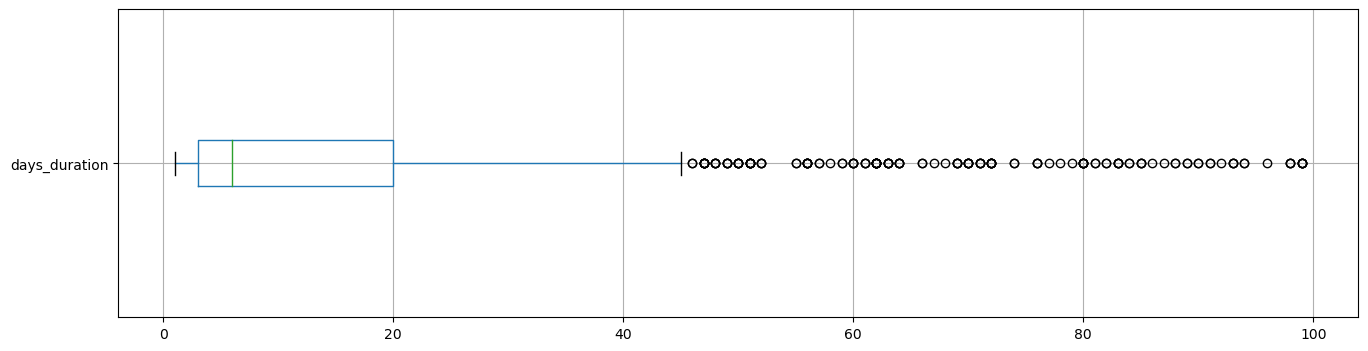

In [129]:
### Diagramme-boîte ou boîte-à-moustache pour représenter la dispersion
# Ligne centrale = la médiane. Le box est entre 1er et 3e quartile
# La moitié de la population se situe entre 31 et 68 ans
#  Noter qu'on utilise le DataFrame car cet objet dispose d'une méthode boxplot
# ce qui n'est pas le cas d'une série (pd.Series)
df_b[(df_b.days_duration > 0) & (df_b.days_duration < 100)] .boxplot(column=['days_duration'], vert=False, figsize=(16,4))

In [130]:
df_b[(df_b.days_duration > 0) & (df_b.days_duration < 100)].days_duration.describe()

count    1401.000000
mean       15.995004
std        21.179622
min         1.000000
25%         3.000000
50%         6.000000
75%        20.000000
max        99.000000
Name: days_duration, dtype: float64

In [87]:
years_count = pd.DataFrame(df_b.groupby('year').size())\
                .reset_index(drop=False)
years_count.columns=['year','effectif']
years_count

,year,effectif
0,-1500,1
1,-1456,1
2,-1324,1
3,-1273,1
4,-1249,1
...,...,...
1283,2019,8
1284,2020,15
1285,2021,6
1286,2022,20


In [111]:
# Effectifs par année

objects = years_count['year']
eff = years_count['effectif']


objects = years_count['year']
eff = years_count['effectif']

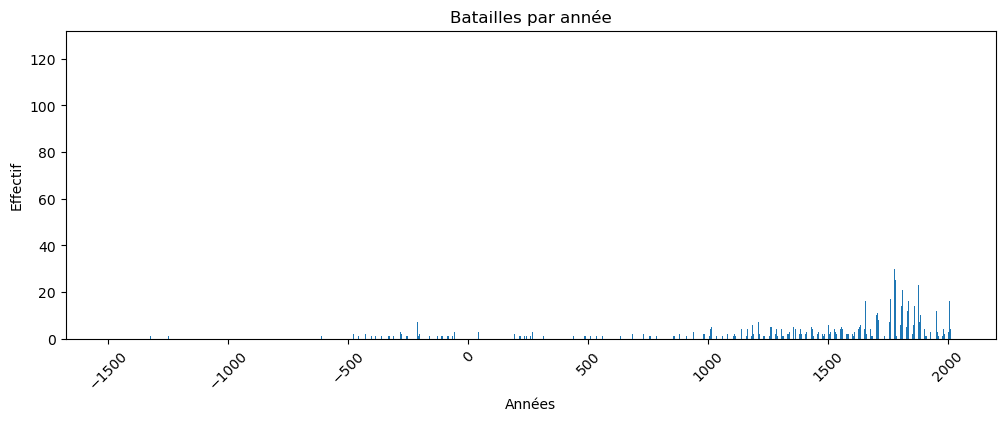

In [111]:
p1 = plt.bar(objects, eff, width=0.5)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Batailles par année')
plt.gcf().set_size_inches(12,4)
plt.ylim(0,max(eff) + 10)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

In [112]:
# Effectifs par année

objects = years_count['year']
eff = years_count['effectif']

years_between = years_count[(years_count.year >1000) & (years_count.year < 1200) ]

print(years_between.head())

     year  effectif
440  1001         3
441  1003         1
442  1004         1
443  1006         1
444  1009         1


<Axes: xlabel='year'>

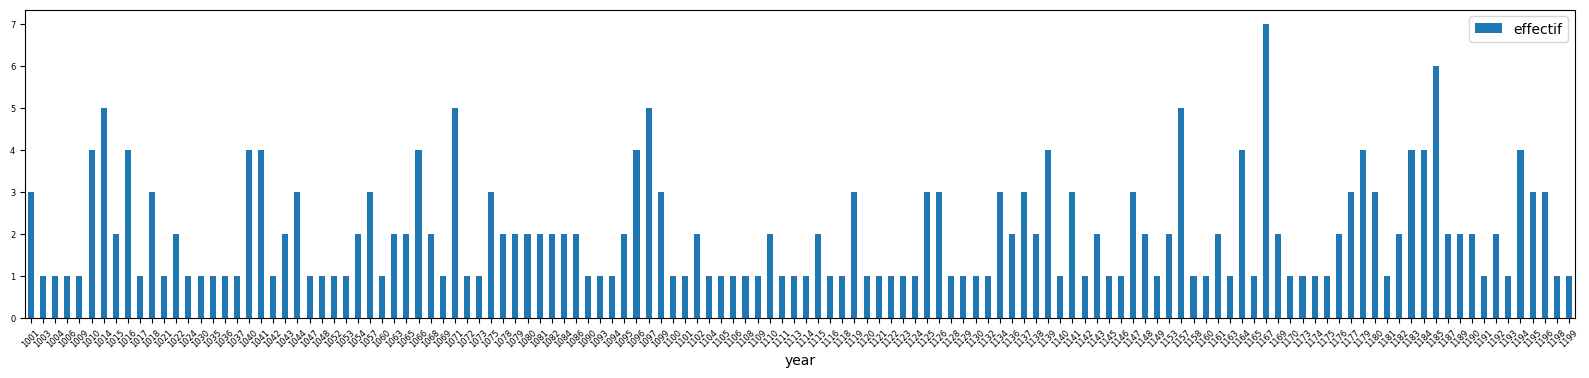

In [121]:
years_between.plot(kind='bar', x='year', figsize=(20,4), rot=45, fontsize=6)

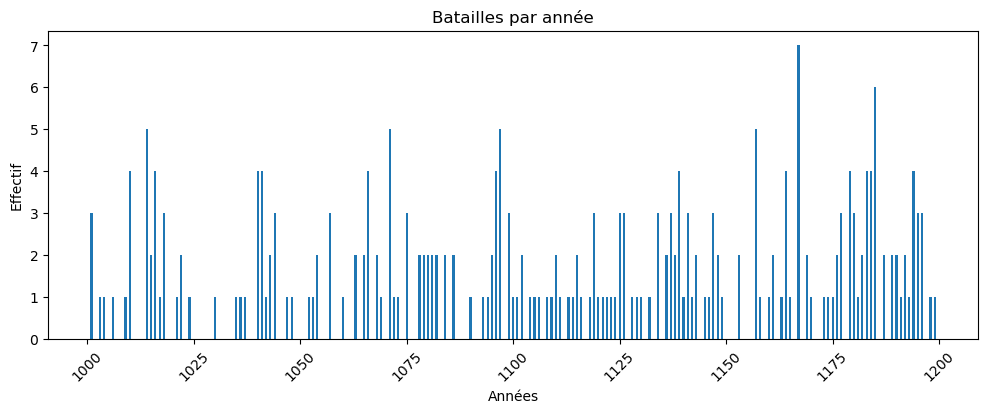

In [114]:
objects = years_between['year']
eff = years_between['effectif']


p1 = plt.bar(objects, eff, width=0.5)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Batailles par année')
plt.gcf().set_size_inches(12,4)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

<Axes: >

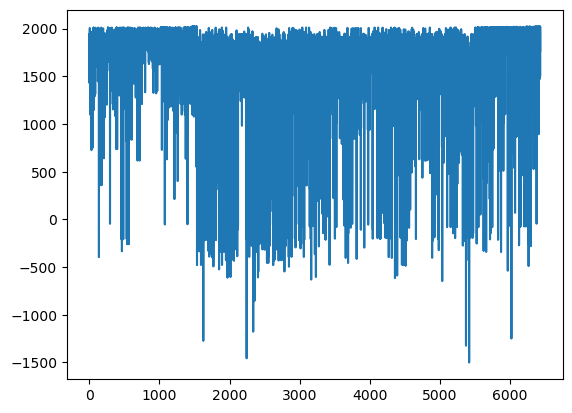

In [36]:
df_b['year'].plot()